In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
np.random.seed(91828)

In [3]:
def class_to_int(label , cl):
    temp = []
    for i in range(len(label)):
        #print(label[i])
        for j in range(len(cl)):
            if(label[i]==cl[j]):
                temp.append(j) 
    return temp
classes = ['BH' ,'NS' ]
ns_n = 0 
bh_n = 0


In [4]:

def get_xy(data):
    y = data['class']
    s = data['significance']
    info = data[['src_n' , 'src_id']]
    x = data.drop(columns=[ 'class' ,'src_n' ,'src_id' , 'significance'])
    #display(x)
    y_train_int = class_to_int(y, classes)
    one_hot_y_train =  to_categorical(y_train_int)
    global ns_n 
    global bh_n
    ns_n = float(y.value_counts()['NS']) 
    bh_n =  float(y.value_counts()['BH'])    
    print(ns_n , bh_n)
    return x , one_hot_y_train

In [5]:
def fit_model(model , x_train , one_hot_y_train , verbose=0 , validation=0.2):
    global ns_n 
    global bh_n 
    class_weight = {0: (ns_n/bh_n),
                    1: 1}
    history = model.fit(x_train, one_hot_y_train, batch_size=64, epochs=120, validation_split=validation, class_weight=class_weight, verbose=verbose )
    return history

In [6]:
from tqdm import tqdm
def mc_validation(model_func , data , s=0.8 , model_name = '' , d_type = '' , impute_method = ''):
    from sklearn.model_selection import KFold
    kfold = KFold(8, True, 1)
    #k-fold cross-validation
    train_acc = []
    test_acc = []
    #s =  int(len(x)*s)
    
    for i in tqdm(range(32)):
        data = data.sample(frac=1)
        x = data.drop(columns=['class' ,'src_n' , 'src_id' ,'significance'])
        y = data['class']
        x_train , x_test ,y_train , y_test =  train_test_split(x,y , test_size=s , stratify=y)
        model = model_func()
        model.fit(x_train,y_train)
        train_acc_temp = (model.score(x_train , y_train))
        test_acc_temp = (model.score(x_test , y_test))
        #print('-----------------------------------')
        #print('training_acc :' , train_acc_temp)
        #print('test_acc :' , test_acc_temp)
        train_acc.append(train_acc_temp)
        test_acc.append(test_acc_temp)
    acc_train =  pd.DataFrame()
    acc_test = pd.DataFrame()

    
    acc_test.insert(0 , 'acc_type' , ['Test_acc']*len(train_acc))
    acc_test.insert(1 , 'accuracy' , test_acc)
    acc_test = acc_test.reset_index(drop=True)
   
    acc_train.insert(0 , 'acc_type' , ['Train_acc']*len(train_acc))
    acc_train.insert(1 , 'accuracy' , train_acc)
    acc_train = acc_train.reset_index(drop=True)

    acc = pd.concat([acc_train , acc_test]).reset_index(drop=True)
    acc.insert(0 , 'model' , [model_name]*len(acc))
    acc.insert(1 , 'data_processing' , [d_type]*len(acc))
    acc.insert(2 , 'impute_method' , [impute_method]*len(acc))
    return acc


In [8]:
data_norm = pd.read_csv('processed_data/train_norm_zero' , index_col=0).reset_index(drop=True)
data_std = pd.read_csv('processed_data/train_std_zero' , index_col=0).reset_index(drop=True)
data_og = pd.read_csv('processed_data/train_og_zero' , index_col=0).reset_index(drop=True)


# Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split

## Imputation Comparison

In [48]:
data_corr = pd.read_csv('processed_data/train_norm_corr_impute' , index_col=0).reset_index(drop=True)
data_zero = pd.read_csv('processed_data/train_norm_zero_impute' , index_col=0).reset_index(drop=True)
data_mean = pd.read_csv('processed_data/train_norm_mean_impute' , index_col=0).reset_index(drop=True)
data_median = pd.read_csv('processed_data/train_norm_median_impute' , index_col=0).reset_index(drop=True)


In [ ]:
acc_zero = mc_validation(data_zero , s=0.2 ,model_name='LR' , d_type='Normalized' , impute_method='Zero').reset_index(drop=True)
acc_mean = mc_validation(data_mean , s=0.2 ,model_name='LR' , d_type='Normalized' , impute_method='mean').reset_index(drop=True)
acc_median = mc_validation(data_median , s=0.2 ,model_name='LR' , d_type='Normalized' , impute_method='median').reset_index(drop=True)
acc_corr = mc_validation(data_corr , s=0.2 ,model_name='LR' , d_type='Normalized' , impute_method='correlation').reset_index(drop=True)

In [62]:
acc_lr_norm = pd.concat([acc_zero , acc_mean , acc_median , acc_corr]).reset_index(drop=True)
acc_lr_norm.to_csv('result/acc_lr_norm_all')


In [54]:
import seaborn as sns

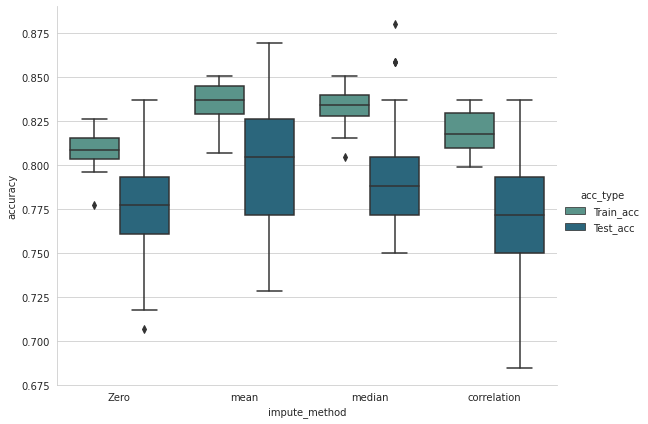

In [65]:
sns.set_style('whitegrid')
sns.catplot(data = acc_lr_norm , y='accuracy' , x = 'impute_method' ,
            hue= 'acc_type'  , kind='box' ,  
            palette = 'crest' , height=6 , aspect=8/6
            )
#plt.savefig('/content/drive/MyDrive/thesis_data/acc_result_plot_violin.jpg')
plt.show()

## Data Processing method 

In [18]:
acc_norm_lr = mc_validation(LR, data_norm , s=0.2 ,model_name='LR' , d_type='Normalized' , impute_method='Zero')
acc_std_lr = mc_validation(LR , data_std , s=0.2 ,model_name='LR' , d_type='Standardized' , impute_method='Zero')
acc_og_lr = mc_validation(LR , data_og , s=0.2 ,model_name='LR' , d_type='None' , impute_method='Zero')

/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
100%|██████████| 32/32 [00:03<00:00, 10.07it/s]
/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
100%|██████████| 32/32 [00:05<00:00,  5.47it/s]
/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
  0%|          | 0/32 [00:00<?, ?it/s

In [19]:
acc_lr = pd.concat([acc_norm_lr , acc_std_lr , acc_og_lr]).reset_index(drop=True)
acc_lr

,model,data_processing,impute_method,acc_type,accuracy
0,LR,Normalized,Zero,Train_acc,0.815217
1,LR,Normalized,Zero,Train_acc,0.828804
2,LR,Normalized,Zero,Train_acc,0.823370
3,LR,Normalized,Zero,Train_acc,0.788043
4,LR,Normalized,Zero,Train_acc,0.798913
...,...,...,...,...,...
187,LR,None,Zero,Test_acc,0.771739
188,LR,None,Zero,Test_acc,0.847826
189,LR,None,Zero,Test_acc,0.739130
190,LR,None,Zero,Test_acc,0.739130


In [21]:
acc_lr.to_csv('result/acc_lr_all_zero')

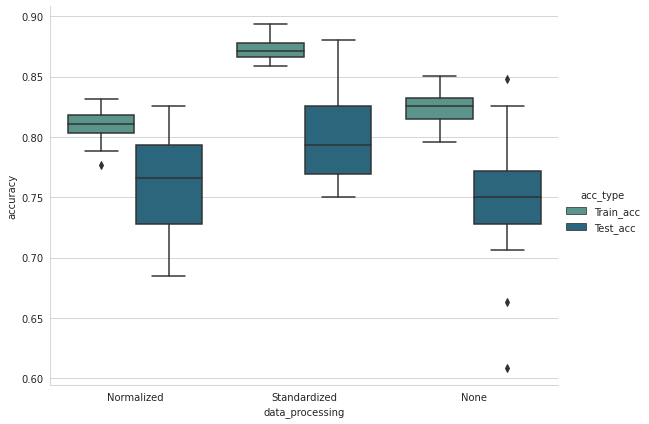

In [20]:
sns.set_style('whitegrid')
sns.catplot(data = acc_lr , y='accuracy' , x = 'data_processing' ,
            hue= 'acc_type'  , kind='box' ,  
            palette = 'crest' , height=6 , aspect=8/6
            )
#plt.savefig('/content/drive/MyDrive/thesis_data/acc_result_plot_violin.jpg')
plt.show()

# K-Nearest Neighbour

In [10]:
from sklearn.neighbors import KNeighborsClassifier as KNN


## Data Imputation comparison

In [ ]:
acc_zero_knn = mc_validation(KNN , data_zero , s=0.2 ,model_name='KNN' , d_type='Normalized' , impute_method='Zero')
acc_mean_knn = mc_validation(KNN , data_mean , s=0.2 ,model_name='KNN' , d_type='Normalized' , impute_method='mean')
acc_median_knn = mc_validation(KNN  , data_median , s=0.2 ,model_name='KNN' , d_type='Normalized' , impute_method='median')
acc_corr_knn = mc_validation(KNN  , data_corr , s=0.2 ,model_name='KNN' , d_type='Normalized' , impute_method='correlation')

In [ ]:
acc_zero_knn = acc_zero_knn.reset_index(drop=True)
acc_mean_knn = acc_mean_knn.reset_index(drop=True)
acc_median_knn = acc_median_knn.reset_index(drop=True)
acc_corr_knn = acc_corr_knn.reset_index(drop=True) 

In [73]:
acc_norm_knn = pd.concat([acc_zero_knn , acc_mean_knn , acc_median_knn , acc_corr_knn]).reset_index(drop=True)
acc_lr_norm.to_csv('result/acc_knn_norm_all')

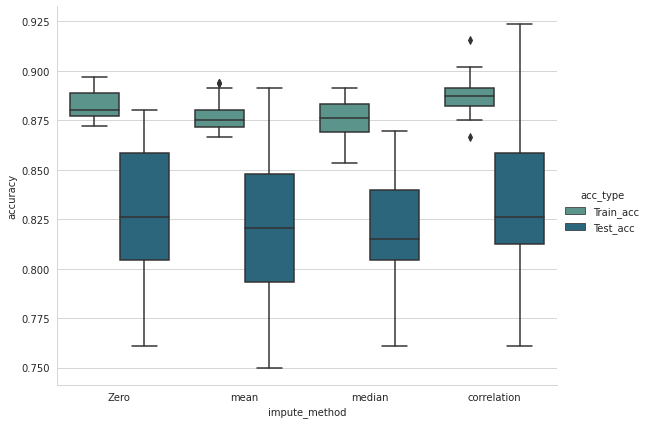

In [75]:
sns.set_style('whitegrid')
sns.catplot(data = acc_norm_knn , y='accuracy' , x = 'impute_method' ,
            hue= 'acc_type'  , kind='box' ,  
            palette = 'crest' , height=6 , aspect=8/6
            )
#plt.savefig('/content/drive/MyDrive/thesis_data/acc_result_plot_violin.jpg')
plt.show()

## Data Processing Method Comparison

In [ ]:
acc_norm_knn = mc_validation(KNN , data_norm , s=0.2 ,model_name='KNN' , d_type='Normalized' , impute_method='Zero')
acc_std_knn = mc_validation(KNN , data_std , s=0.2 ,model_name='KNN' , d_type='Standardized' , impute_method='Zero')
acc_og_knn = mc_validation(KNN , data_og , s=0.2 ,model_name='KNN' , d_type='None' , impute_method='Zero')

In [12]:
acc_knn = pd.concat([acc_norm_knn , acc_std_knn , acc_og_knn]).reset_index(drop=True)
acc_knn

,model,data_processing,impute_method,acc_type,accuracy
0,KNN,Normalized,Zero,Train_acc,0.885870
1,KNN,Normalized,Zero,Train_acc,0.872283
2,KNN,Normalized,Zero,Train_acc,0.894022
3,KNN,Normalized,Zero,Train_acc,0.888587
4,KNN,Normalized,Zero,Train_acc,0.885870
...,...,...,...,...,...
187,KNN,None,Zero,Test_acc,0.706522
188,KNN,None,Zero,Test_acc,0.728261
189,KNN,None,Zero,Test_acc,0.815217
190,KNN,None,Zero,Test_acc,0.793478


In [14]:
import seaborn as sns

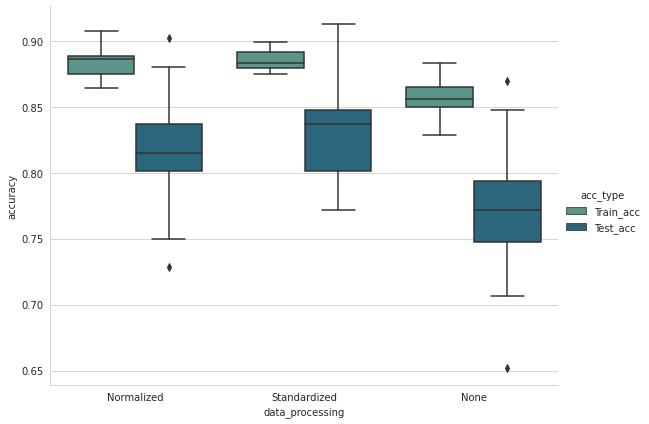

In [15]:
sns.set_style('whitegrid')
sns.catplot(data = acc_knn , y='accuracy' , x = 'data_processing' ,
            hue= 'acc_type'  , kind='box' ,  
            palette = 'crest' , height=6 , aspect=8/6
            )
#plt.savefig('/content/drive/MyDrive/thesis_data/acc_result_plot_violin.jpg')
plt.show()

In [22]:
acc_knn.to_csv('result/acc_knn_all_zero')